In [23]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException, ElementClickInterceptedException



In [24]:
# clear csv
f = open('data/scrapedLinks_bbc.csv', "w+")
f.close()

# Part 1: Analyze the Fake News Dataset


## 1.1: Import dataset from Ex 1

In [25]:
#load data
dataPath = "data/"
Cleaned_data = pd.read_csv(dataPath + "cleanedData.csv")

## 1.2 Dataset Analysis

### Determine which article types should be omitted, if any.


In [26]:
typelist = Cleaned_data['type'].unique()
print(typelist)

['unreliable' 'fake' 'clickbait' 'conspiracy' 'reliable' 'bias' 'hate'
 'junksci' 'political' nan 'unknown']


Assuming that the data will be used to train a classifier such as the one in the course project, there are some types that should be omitted. These are the ones that are note certainly either fake or reliable. If a type cant be given one of our two labels they cannot be used for training.

    Unknown: If we dont know the article type, it cant be placed in either label.

    nan: Omitted for same reason as unknown

    Unreliable: The documentation describes it as "Sources that may be reliable but whose contents require further verification." Which may as well be unknown, and will thus be ommitted for the same reasons as above.

In [27]:
Cleaned_data = Cleaned_data.dropna(subset=['type'])
Cleaned_data = Cleaned_data.loc[Cleaned_data['type']!='unknown']
Cleaned_data = Cleaned_data.loc[Cleaned_data['type']!='unreliable']

In [28]:
# Get the counts for each unique type
type_counts = Cleaned_data['type'].value_counts()

# Print the counts
for types, count in type_counts.items():
    print(types, ":", count)

fake : 155
conspiracy : 31
political : 23
bias : 6
junksci : 6
reliable : 3
clickbait : 1
hate : 1


### Group the remaining types into 'fake' and 'reliable'. Argue for your choice.

### Fake
    Fake           
    Conspiracy
    Bias
    Junksci
    Hate

From the documentaion it can be seen that Conspiracy, Hate, bias and junksci are mostly made up either of statements misrepresenting fact or of content that is either highly biased by or entirely based on belief. In either case content that is not backed by science or fact. Fake is fake
    
### Reliable
    Political
    Reliable
    Clickbait

Political and Clickbait are both described as generally reliable, with slight bias or inaccuracy. Reliable is reliable.

In [ ]:
# groups (reliable, political and clickbait) as truenews 1 and (all others) in fakenews 0 
    #note this is naive and should be reconsidered later
Cleaned_data['type'] = Cleaned_data['type'].replace({'^reliable$': '1', '^political$': '1', '^clickbait$': '1'}, regex=True)
Cleaned_data['type'] = Cleaned_data['type'].replace(r'^(?!1$).+', '0', regex=True)   # Replace everything except '1' with '0'



### Examine the percentage distribution of 'reliable' vs. 'fake' articles. Is the dataset balanced? Discuss the importance of a balanced distribution.

In [30]:
# Get the counts for each unique type
countFake, countReliable = Cleaned_data['type'].value_counts()
countTotal = countFake + countReliable

labels = ['fake', 'true']
PercentageValues = [countFake / countTotal * 100, countReliable / countTotal * 100]

percentage_df = pd.DataFrame({
    'Type': labels,
    'Percentage': PercentageValues
})

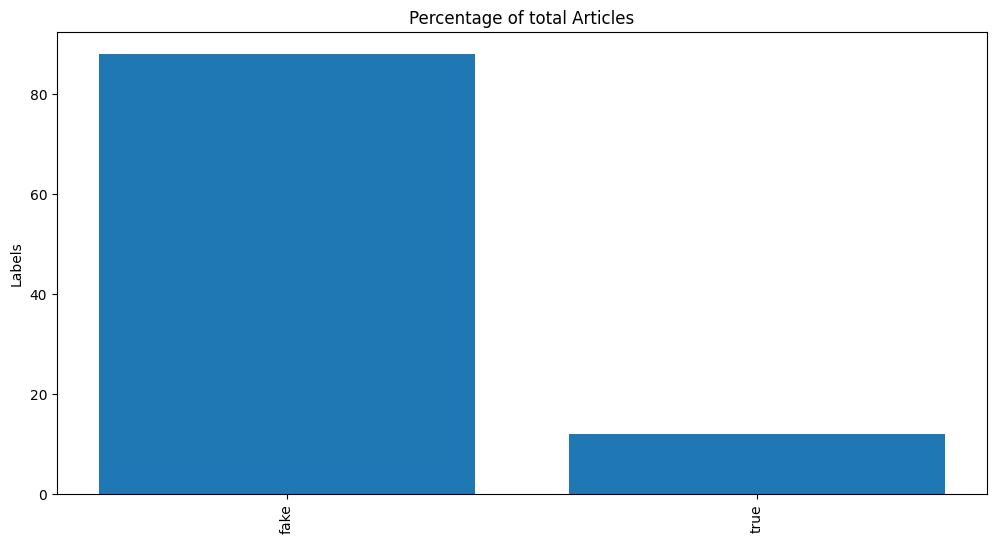

fake percentage: 88.05309734513274
reliable percentage: 11.946902654867257
relation: 7.37037037037037


In [31]:
fig, ax = plt.subplots(figsize=(12, 6)) 

ax.bar(percentage_df['Type'], percentage_df['Percentage'], color= 'tab:blue')

ax.set_ylabel('Labels')
ax.set_title('Percentage of total Articles')
plt.xticks(rotation=90)

plt.show()
print('fake percentage:',countFake / countTotal * 100)
print('reliable percentage:',countReliable / countTotal * 100)
print('relation:', countFake / countReliable)

The data is highly unbalanced in favor of fake articles, with a ratio of approximately 1:7. For a model to effectively learn the distinguishing features of each class, it is beneficial to expose it to an even distribution of both classes. In cases like ours, where one class dominates the data, a model trained on such an imbalanced dataset may become biased. It could overfit by learning the statistical advantage of predicting the majority class, rather than learning the distinct features that differentiate both classes. As a result, the model might predict the majority class disproportionately, regardless of the content, and fail to accurately identify the minority class.

# Part 2: Gathering Links


## 2.1: Install Library

dddddonneeee

## 2.2: Retrieve HTML Content

In [ ]:

options = Options()
options.add_argument("-profile")
options.add_argument("/home/andreas-linus-thalund-midtgaard/snap/firefox/common/.mozilla/firefox/kao2pljk.default")   #replace with path on you setup

#had some troubles with library. Above turned out to be necessary

browser = webdriver.Firefox(options=options)
browser.get("https://www.bbc.com/news/world/europe")

#get html
html = browser.page_source
time.sleep(2)
print(html)

# close web browser
browser.close()

<html lang="en-GB"><head><meta charset="utf-8"><meta name="viewport" content="width=device-width"><title>Europe | Latest News &amp; Updates | BBC News</title><meta property="og:title" content="Europe | Latest News &amp; Updates | BBC News"><meta name="twitter:title" content="Europe | Latest News &amp; Updates | BBC News"><meta name="description" content="Get all the latest news, live updates and content about Europe from across the BBC."><meta property="og:description" content="Get all the latest news, live updates and content about Europe from across the BBC."><meta name="twitter:description" content="Get all the latest news, live updates and content about Europe from across the BBC."><meta name="msapplication-TileColor" content="#da532c"><meta name="theme-color" content="#ffffff"><meta name="robots" content="NOODP, NOYDIR"><meta name="apple-itunes-app" content="app-id=364147881, app-argument=https://www.bbc.com/news/world/europe"><link rel="apple-touch-icon" sizes="180x180" href="/bb

## 2.3 Extract Articles

In [33]:
def extractArticle():
    unique_articles = set()
    browser = webdriver.Firefox(options=options)
    browser.get("https://www.bbc.com/news/world/europe")
    time.sleep(2)

    #find link class containing headlines and summaries (articles) 
    articles = browser.find_elements(By.XPATH, "//a[count(.//h2) = 1 and .//p]")


    #Extract links, headlines and summaries from articles
    for article in articles:

        h2_element = article.find_element(By.XPATH, ".//h2")
        headline = h2_element.text.strip()       

        p_element = article.find_element(By.XPATH, ".//p")
        summary = p_element.text.strip()

        link = article.get_attribute("href")
        
        # Convert relative links to absolute
        if link and link.startswith("/"):
            link = "https://www.bbc.com" + link

        #ensure no dublicates
        if not headline or not summary or not link:
            continue
        article_tuple = (headline, summary, link)
        if article_tuple not in unique_articles:
            unique_articles.add(article_tuple)
            print("\nArticle:")
            print("  Headline:", headline)
            print("  Summary:", summary)
            print("  Link:", link)




    browser.quit()




In [34]:
extractArticle()


Article:
  Headline: Paris trains halted and area evacuated after WW2 bomb found
  Summary: The unexploded bomb was found on tracks near the station, with all Paris trains, plus Eurostar to Brussels, suspended.
  Link: https://www.bbc.com/news/articles/cvg13rmnvzvo

Article:
  Headline: Hundreds evacuated at site of WW2 bomb after Eurostar cancels all Paris trains
  Summary: Police have blocked rail services to and from Gare du Nord after an unexploded device was found on the tracks in the Saint-Denis district.
  Link: https://www.bbc.com/news/live/cz6l257gnjqt

Article:
  Headline: Listen: Pope Francis shares voice message from hospital
  Summary: The 88-year-old had not been seen or heard by the public since he was admitted to hospital on 14 February.
  Link: https://www.bbc.com/news/videos/cd65nl7n6y9o

Article:
  Headline: Pelicots' daughter presses charges against father jailed in mass rape case
  Summary: Caroline Darian - who says she is her father's "forgotten victim" - is con

## 2.4 & 2.5: Web Scraping - Links

Function that scrapes the links for each article on all pages for all regions and saves to disk.

In [ ]:
def scrapeTheBBC():
    browser = webdriver.Firefox(options=options)
    browser.get("https://www.bbc.com/news/world/europe")
    time.sleep(1)

    articleLinks = set()

    linksToTheWorld = [
        "/news/us-canada", 
        "/news/uk", 
        "/news/world/africa", 
        "/news/world/asia", 
        "/news/world/australia", 
        "/news/world/latin_america", 
        "/news/world/middle_east"
    ]

    for worldlink in linksToTheWorld:  
        while True:
                #scroll to bottom so paginator is loaded
                browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                time.sleep(2)



                #scrape data
                #find link class containing headlines and summaries (articles) 
                articles = browser.find_elements(By.XPATH, "//a[count(.//h2) = 1 and .//p]")
                
                #extract link
                for article in articles:
                    h2_element = article.find_element(By.XPATH, ".//h2")
                    headline = h2_element.text.strip()       

                    p_element = article.find_element(By.XPATH, ".//p")
                    summary = p_element.text.strip()
                    
                    link = article.get_attribute("href")

                    # Convert relative links to absolute
                    if link and link.startswith("/"):
                        link = "https://www.bbc.com" + link

                    #ensure no dublicates
                    if not headline or not summary or not link:
                        continue

                    #sorting out non-articles
                    #if "/sport/" in link or "/videos/" in link:
                    #    continue

                    if link not in articleLinks:
                        articleLinks.add(link)
                        print("\nArticle:")
                        print("  Headline:", headline)
                        print("  Summary:", summary)
                        print("  Link:", link)


                #find "next page" button and break loop if it does not exist or is dissabelled
                next_buttons = browser.find_elements(By.XPATH, "//button[@data-testid='pagination-next-button']")
                if not next_buttons:
                    break

                next_button = next_buttons[0]
                if not next_button.is_enabled():
                    break
                
                #go to next page
                next_buttons[0].click()  
                time.sleep(2)
                
            
        region_url = "https://www.bbc.com" + worldlink
        browser.get(region_url)  # Navigate to the next region page
        time.sleep(3)  # Allow the page to load
        

    # close web browser
    browser.quit()
    return articleLinks




In [46]:
scraped_linksbbc = scrapeTheBBC()


Article:
  Headline: Paris trains halted and area evacuated after WW2 bomb found
  Summary: The unexploded bomb was found on tracks near the station, with all Paris trains, plus Eurostar to Brussels, suspended.
  Link: https://www.bbc.com/news/articles/cvg13rmnvzvo

Article:
  Headline: Hundreds evacuated at site of WW2 bomb after Eurostar cancels all Paris trains
  Summary: Police have blocked rail services to and from Gare du Nord after an unexploded device was found on the tracks in the Saint-Denis district.
  Link: https://www.bbc.com/news/live/cz6l257gnjqt

Article:
  Headline: Listen: Pope Francis shares voice message from hospital
  Summary: The 88-year-old had not been seen or heard by the public since he was admitted to hospital on 14 February.
  Link: https://www.bbc.com/news/videos/cd65nl7n6y9o

Article:
  Headline: Pelicots' daughter presses charges against father jailed in mass rape case
  Summary: Caroline Darian - who says she is her father's "forgotten victim" - is con

In [ ]:
scrapedLinks_BBC = scraped_linksbbc

scrapedLinks_BBC_df = pd.DataFrame(list(scrapedLinks_BBC), columns=['Links'])

#sorting out remaining non-articles
#scrapedLinks_BBC_df = scrapedLinks_BBC_df[scrapedLinks_BBC_df['Links'].str.contains('/articles/')]

#save results in csv

scrapedLinks_BBC_df.to_csv('data/scrapedLinks_bbc.csv', index=False) 

In [64]:
print(scrapedLinks_BBC_df)

                                                 Links
0    https://www.bbc.com/news/world-latin-america-2...
1       https://www.bbc.com/news/articles/cgj5819dnpqo
2       https://www.bbc.com/news/articles/crlxz41jxw2o
3       https://www.bbc.com/news/articles/c9d5zqg3228o
4       https://www.bbc.com/news/articles/cnvqle40183o
..                                                 ...
754       https://www.bbc.com/news/videos/cn4yzywpy72o
755       https://www.bbc.com/news/videos/c33715jp6n4o
756       https://www.bbc.com/news/videos/c0q184n7qnjo
757     https://www.bbc.com/news/articles/cvg8lnnge8po
758     https://www.bbc.com/news/articles/cvgxz76m1g8o

[759 rows x 1 columns]


about 800..

# Part 3: Scraping Article Text


## 3.1: Article Inspection

There is and article tag, and the first h1 tag after this seems to be the headline.

Any p tags withing article tag seem to contain only text.

The first instance of time tag indicatesthe published date

and the author can be found by the simple rule of:
Author= //*[@id="main-content"]/article/div[2]/div/div[2]/div/div/span



## 3.2: Scraping function given link

Function that takes a URL and returns a dictionary with the articles content

In [59]:
scrapedLinks_BBC_df = pd.read_csv(dataPath + "scrapedLinks_bbc.csv")

In [61]:
#user is responsible for creating and closing browser
def scrapeText(link):
    browser.get(link)
    time.sleep(2)

    # Extracting content
    try:
        headline = browser.find_element(By.XPATH, "//article//h1").text
    except NoSuchElementException:
        headline = "n/a"
    try:
        published_date = browser.find_element(By.XPATH, "//article//time").get_attribute("datetime")
    except NoSuchElementException:
        published_date = "n/a"
    try:
        author = browser.find_element(By.XPATH, '//*[@id="main-content"]/article/div[2]/div/div[2]/div/div/span').text
    except NoSuchElementException:
        author = "n/a"
    try:
        article_paragraphs = browser.find_elements(By.XPATH, "//article//p")
        article_text = "\n".join([p.text for p in article_paragraphs])
    except NoSuchElementException:
        article_text = "n/a"


    #creating article dict
    article = {
        "Content": article_text,
        "Published": published_date,
        "Title": headline,
        "Author": author
 
    }

    return article
    
    
    

In [62]:
options = Options()
options.add_argument("-profile")
options.add_argument("/home/andreas-linus-thalund-midtgaard/snap/firefox/common/.mozilla/firefox/kao2pljk.default")  # Replace with your actual profile path

browser = webdriver.Firefox(options=options)
print(scrapeText(scrapedLinks_BBC_df.iloc[1]["Links"]))
browser.quit()

{'Content': 'Actor Morgan Freeman has led tributes at the annual Academy Awards ceremony to fellow Hollywood star Gene Hackman, whose death last month is under police investigation.\n"This week, our community lost a giant and I lost a dear friend," said Freeman, who worked with Hackman in two films, including 1992\'s Unforgiven, which won Hackman his second Oscar.\n"Like everyone who ever shared a scene with him I learned he was a generous performer whose gifts elevated everyone\'s work," Freeman said.\nHackman, 95, and his wife Betsy Arakawa, 65, were found dead at their home in New Mexico days ago.\n"He received two Oscars but more importantly he won the hearts of film-lovers all over the world," Freeman said in his speech during Sunday night\'s 97th Academy Awards ceremony in Los Angeles.\nHe added that Hackman had told him: "I don\'t think about legacy, I just hope people remember me as someone who tried to do good work."\n"Gene, you\'ll be remembered for that and so much more. Res

## 3.3 & 3.4: Scrape articles from all links and save the data to disc

In [71]:
scrapedArticles_df = pd.DataFrame({'Content': [], 'Published': [], 'Title': [], 'Author': []})

In [72]:
# clear csv
f = open('data/scrapedContent_bbc.csv', "w+")
f.close()

In [ ]:
options = Options()
options.add_argument("-profile")
options.add_argument("/home/andreas-linus-thalund-midtgaard/snap/firefox/common/.mozilla/firefox/kao2pljk.default")  # Replace with your actual profile path

browser = webdriver.Firefox(options=options)

for i in range (120, len(scrapedLinks_BBC_df)):
    #attempt to scrape article
    try:
        scrapedArticles_df = pd.concat([scrapedArticles_df, pd.DataFrame([scrapeText(scrapedLinks_BBC_df.iloc[i]["Links"])])], ignore_index=True)

    #error handling for debugging
    except:
        print("stopped at:", i, scrapeText(scrapedLinks_BBC_df.iloc[i]["Links"]))
        scrapedLinks_BBC_df.iloc[i].to_csv('data/synder_bbc.csv', index=False) 
        scrapedArticles_df.to_csv('data/scrapedContent_bbc.csv', index=False)
        break 
    
    #save progress every ten article
    if i % 10 == 0:
        scrapedArticles_df.to_csv('data/scrapedContent_bbc.csv', index=False)
        print(f"Saved progress at {i} articles.")
    # Delay --- although bbc doesńt explicitly state a max request rate (https://www.bbc.com/robots.txt)
    delay = random.uniform(2, 5)  
    time.sleep(delay)

browser.quit()

#save to csv
scrapedArticles_df.to_csv('data/scrapedContent_bbc.csv', index=False) 

Saved progress at 120 articles.
Saved progress at 130 articles.
Saved progress at 140 articles.
Saved progress at 150 articles.
Saved progress at 160 articles.
Saved progress at 170 articles.
Saved progress at 180 articles.
Saved progress at 190 articles.
Saved progress at 200 articles.
Saved progress at 210 articles.
Saved progress at 220 articles.
Saved progress at 230 articles.
Saved progress at 240 articles.
Saved progress at 250 articles.
Saved progress at 260 articles.
Saved progress at 270 articles.
Saved progress at 280 articles.
Saved progress at 290 articles.
Saved progress at 300 articles.
Saved progress at 310 articles.
Saved progress at 320 articles.
Saved progress at 330 articles.
Saved progress at 340 articles.
Saved progress at 350 articles.
Saved progress at 360 articles.
Saved progress at 370 articles.
Saved progress at 380 articles.
Saved progress at 390 articles.
Saved progress at 400 articles.
Saved progress at 410 articles.
Saved progress at 420 articles.
Saved pr

Failed at 
120: ReadTimeoutError

## 3.5: Will it make sense to include this data in the project?

The BBC is generally considered a trustworthy source, but without fact-checking each of the 600+ articles individually, we cannot be certain of their accuracy. Even in the best of cases reliable news sources can occasionally produce politically biased or clickbait content. This would not be the biggest issue as we have still chosen to classify these as reliable. In the worst case however, our assumption of total reliability is entirely incorrect, in which case we risk training our model on mislabeled data, leading to skewed results. Thus there is also a clear reason for why including this new data may be unwise.

In [76]:
n_a_counts = (scrapedArticles_df == "n/a").sum()
print(n_a_counts)


Content        0
Published     93
Title         93
Author       178
dtype: int64


There seems to be a noninsignificant amount of empty entries. This is most likely due to the scraper being written for bbc articles. Therefore pages that fall outside of this (like videos or sport) are most likely not scraped correctly. (could also be due to lows in network speed making pages not load entirely, a possibility supported by the timeouterror)